In [1]:
from astropy.table import Table
from datetime import timedelta
from glob import glob

import pandas as pd
from pathlib import Path
import matplotlib.pylab as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import os

import sys
import random, string

# tensorflow
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.models import model_from_yaml
from tensorflow.keras.callbacks import CSVLogger

from time import gmtime, strftime
import time 

In [2]:
from os.path import expanduser
home = expanduser("~")

sys.path.append(home+'/repos/ClusNet/code/modules/')

from ClusNet import Cluster
from ClusNet import model as m

Define model parameters

In [3]:
# data
im_size = 384
k = 0.02 # percentage of 

# compiler
metrics = ["accuracy"]
opt=tf.keras.optimizers.Adam(lr=0.005)

# training 
epochs = 10
input_shape = (im_size,im_size,1) # width, height, channel number
pool_size = (2,2)
kernel_size = (3,3)
activation = 'relu'
strides = 2

# GPU
batch_size = 2

Define environment settings

In [4]:
# tensorflow 
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# plot
label_size = 14
mpl.rcParams['legend.fontsize'] = label_size
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.labelpad'] = 10
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size

# print
np.set_printoptions(precision=3, suppress=True)

Generate model

In [5]:
# generate model
model = m.generate_model(kernel_size=kernel_size,
                         pool_size=pool_size,
                         activation=activation,
                         strides=2,
                         input_shape=input_shape)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 384, 384, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 192, 192, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 192, 192, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0

Compile model

In [6]:
# compile model
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer=opt,
              loss=loss,
              metrics=metrics)

Load data

In [7]:
# load data
training_data, validation_data, modeldir = Cluster.load_dataset(k=0.8,validation_split=0.20,noise=True)
x_train, y_train = training_data
validation_x, validation_y = validation_data

Loading 1874 clusters...
-Adding 1874 negatives...
Done.

Training image shape: (2998, 384, 384, 1)
Training labels shape: (2998, 1)
y_train [[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]

Validation image shape: (750, 384, 384, 1)
Validation labels shape: (750, 1)
y_validation []

Model directory created --> /Users/erebor/repos/ClusNet/models/category/CnIKe

Saving dataset paths to--> /Users/erebor/repos/ClusNet/models/category/CnIKe


0.0 0.07552083333333333
0.0 0.25
0.0 0.0625
0.0 0.19791666666666666
0.0 0.028645833333333332
0.0 0.0234375
0.0 0.0078125
0.0 0.010416666666666666
0.0 0.010416666666666666
0.0 0.2916666666666667
0.0 0.044270833333333336
0.0 0.010416666666666666
0.0 0.015625
0.0 0.0078125
0.0 0.010416666666666666
0.0 0.03125
0.0 0.0078125
0.0 0.0078125
0.0 0.0078125
0.0 0.010416666666666666
0.0 0.010416666666666666
0.0 0.08854166666666667
0.0 0.1484375
0.0 0.010416666666666666
0.0 0.125


<ipython-input-8-3645099e344d>:28: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Spectral"))
  cmap.set_bad(color='white')
<ipython-input-8-3645099e344d>:29: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(image),interpolation='none',cmap=cmap)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


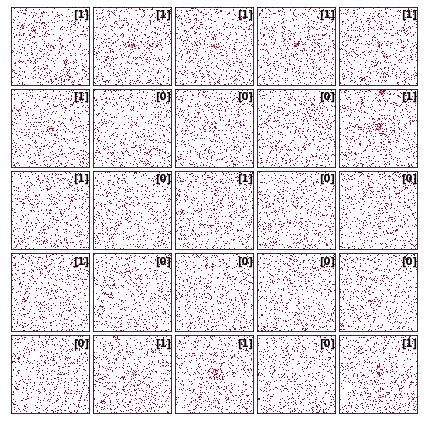

In [8]:
size=5
nrows = size
ncols = size
k = nrows * ncols
fig, axes = plt.subplots(nrows=nrows,
                         ncols=ncols,
                         figsize=(6,6))


#clusglob = glob(globdir + '*.fits')
#clusfpaths = random.choices(clusglob,k=k)

dataset = x_train
labels = y_train


x = list(range(1874))
random.shuffle(x)
idx = random.choices(x, k=k)

dataset = np.array(dataset)[idx]
labels = np.array(labels)[idx]

for i, ax in enumerate(axes.flat):
    image = dataset[i]
    print(np.min(image),np.max(image))
    cmap = plt.cm.Spectral
    cmap.set_bad(color='white')
    ax.imshow(np.log10(image),interpolation='none',cmap=cmap)
    ax.text(0.90, 0.90,labels[i],
            horizontalalignment='center',
            verticalalignment='center',
            transform = ax.transAxes,
            color="black",
           weight='bold')
    ax.set_yticks([]), ax.set_xticks([])

space = 0.05
plt.tight_layout()
plt.subplots_adjust(wspace=space,hspace=space)
#plt.savefig(fpath,dpi=300)
plt.show()
plt.close()

Train model

In [9]:
print("\n********LEARNING START********")
start = time.time()

model_id = os.path.basename(os.path.normpath(modeldir))

csv_logger = CSVLogger(modeldir + '/history_{}.log'.format(model_id),
                       separator=',',
                       append=False)

history = model.fit(x=x_train,
                    y=y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_x, validation_y),
                    verbose=2,
                   callbacks=[csv_logger])



print("********LEARNING END********")
elapsed = time.time() - start
print("\nTIME:",str(timedelta(seconds=elapsed)))


********LEARNING START********
Epoch 1/10
1499/1499 - 133s - loss: 0.6937 - accuracy: 0.5170 - val_loss: 0.6946 - val_accuracy: 0.5027
Epoch 2/10


KeyboardInterrupt: 

In [ ]:
# save model assets
print("\nModel assets saved to:", modeldir)
model.save(modeldir)

# plot loss and accuracy
m.plot_metrics(history=history,
             spath=modeldir,
             model_id=model_id)

y_train_model = model.predict(x_train,verbose=1,batch_size=batch_size)
validation_y_model = model.predict(validation_x,verbose=1,batch_size=batch_size)

# plot 1-to-1
m.plot_1to1(y_train=y_train,
          y_train_model=y_train_model,
          validation_y=validation_y,
          validation_y_model=validation_y_model,
          spath=modeldir,
          model_id=model_id)

# plot residuals
m.plot_resid(y_train=y_train,
          y_train_model=y_train_model,
          validation_y=validation_y,
          validation_y_model=validation_y_model,
          spath=modeldir,
          model_id=model_id)